In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble, IBMQ, execute
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_histogram
from qiskit.opflow import Z, X, Y, I, StateFn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.opflow import Gradient, NaturalGradient, PauliExpectation, CircuitSampler
from qiskit_machine_learning.neural_networks import OpflowQNN, CircuitQNN
from qiskit.algorithms.optimizers import GradientDescent
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier, MultiClassObjectiveFunction
from qiskit.utils import QuantumInstance
import copy

%matplotlib inline

In [2]:
backend = Aer.get_backend('qasm_simulator')
q_instance = QuantumInstance(backend, shots = 1024, seed_simulator = 2718, seed_transpiler = 2718)

In [3]:
num_state = {
    0: '0011',
    1: '0101',
    2: '1010',
    3: '1100'
}

def random_states():
    states = []
    str_inp_states = []
    
    while len(states) < 4:
        qc = QuantumCircuit(4)
        qc.h(range(4))
        qc.measure_all()
        sim = Aer.get_backend('statevector_simulator')
        input_state = list(sim.run(assemble(qc)).result().get_counts())[0]
        if input_state not in str_inp_states:
            output_state = len(states)
            str_inp_states.append(input_state)
            states.append([[int(x) for x in list(input_state)], [output_state]])
            
    a = []
    for s in states:
        a0 = s[0]
        for a1 in s[1]:
            a0.append(a1)
        a.append(a0)
    
    return a

In [4]:
training_states = random_states()
training_states

[[1, 1, 1, 0, 0], [1, 1, 0, 1, 1], [1, 0, 1, 0, 2], [0, 0, 1, 0, 3]]

In [5]:
df = pd.DataFrame({})
for i in range(200):
    choice = np.array(training_states[np.random.randint(0, 4)])
    df = df.append([choice.ravel().tolist()], ignore_index=True)
df.columns = ['x0', 'x1', 'x2', 'x3', 'y']

In [6]:
df.head()

,x0,x1,x2,x3,y
0,1,1,0,1,1
1,1,1,1,0,0
2,1,1,0,1,1
3,1,0,1,0,2
4,1,0,1,0,2


In [7]:
features = ['x0', 'x1', 'x2', 'x3']
target = 'y'

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[features].to_numpy(), df[target].to_numpy(), test_size=0.2)

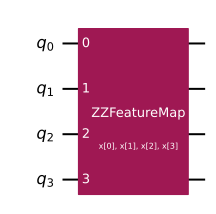

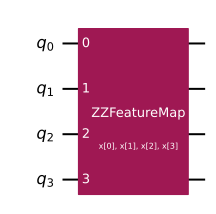

In [9]:
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='circular', insert_barriers=True)
feature_map.draw('mpl', style='iqx')

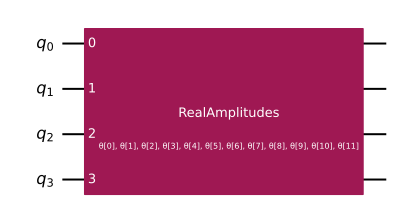

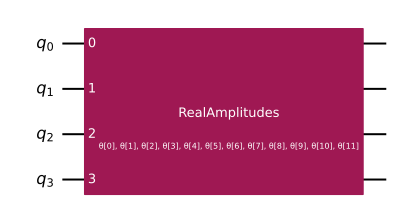

In [10]:
ansatz = RealAmplitudes(num_qubits=4, entanglement='circular', reps=2)
ansatz.draw('mpl', style='iqx')

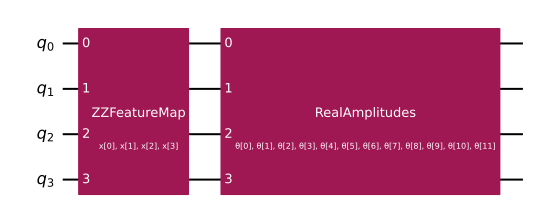

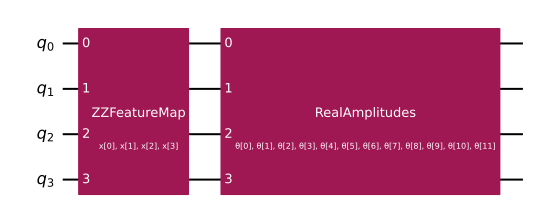

In [11]:
circuit = feature_map.compose(ansatz)
circuit.draw('mpl', style='iqx')

In [12]:
gd_loss = []
def gd_callback(*args):
    gd_loss.append(args[2])
    
gd = GradientDescent(maxiter=100, learning_rate=0.01, callback=gd_callback)

In [13]:
def parity(x):
    return '{:b}'.format(x).count('1') % 2

In [14]:
output_shape = 4

qnn = CircuitQNN(circuit=circuit,
                 input_params=list(feature_map.parameters),
                 weight_params=list(ansatz.parameters),
                 interpret=parity,
                 output_shape=output_shape,
                 gradient=Gradient(),
                 quantum_instance=q_instance)

In [15]:
classifier = NeuralNetworkClassifier(qnn, optimizer=gd)

In [ ]:
classifier.fit(X_train, y_train)

In [ ]:
score = classifier.score(X_test, y_test)
print(f'Classification score: {score}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gd_loss, label='vanilla gradient descent')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()

In [ ]:
qng_loss = []
def qng_callback(*args):
    qng_loss.append(args[2])
    
gd_ng = GradientDescent(maxiter=100, learning_rate=0.01, callback=qng_callback)

In [ ]:
qnn_ng = CircuitQNN(circuit=circuit,
                    input_params=list(feature_map.parameters),
                    weight_params=list(ansatz.parameters),
                    interpret=parity,
                    output_shape=output_shape,
                    gradient=NaturalGradient(regularization='ridge'),
                    quantum_instance=q_instance)

In [ ]:
classifier_ng = NeuralNetworkClassifier(qnn_ng, optimizer=gd_ng)

In [ ]:
classifier_ng.fit(X_train, y_train)

In [ ]:
score_ng = classifier_ng.score(X_test, y_test)
print(f'Classification score: {score_ng}')

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(gd_loss, 'tab:blue', label='vanilla gradient descent')
plt.plot(qng_loss, 'tab:green', label='quantum natural gradient')
plt.axhline(-1, ls='--', c='tab:red', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()